In [1]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import numpy as np
import time
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" * 2))
sys.path.insert(0, BASE_DIR)

from setting import plt
from dataset.bivariate.data_generator import DataGenerator
from giefstat.estimate import cal_assoc

Use environmental variables in default.yml


In [2]:
def load_data(func: str, N: int):
    data_gener = DataGenerator()
    x, y, _, _ = data_gener.gen_data(N, func, normalize=False)
    return x, y


def cal_time_cost(method: str, func: str, N: int, amp: float=0.1, repeats: int=100) -> list:
    x, y = load_data(func, N)
    y_range = np.max(y) - np.min(y)
    noise = np.random.uniform(-amp * y_range, amp * y_range, y.shape)
    y += noise

    tc_list = []
    print(f"\nmethod: {method}")
    for i in range(repeats + 1):
        print(f"\r i = {i}", end="")
        ts = time.time()
        
        if method == "MI-GIEF":
            cal_assoc(x, y, method, xtype="c", ytype="c", k=3)
        else:
            cal_assoc(x, y, method)
        
        if i != 0:
            tc_list.append(time.time() - ts + np.random.random() * 1e-5)
    return tc_list

In [3]:
methods = [
    "PearsonCorr", "SpearmanCorr", "DistCorr", "MI-cut", "MI-qcut", "MI-Darbellay", "MI-KDE", 
    "MI-GIEF", "MIC", "RMIC"]

N_lst = [500, 1000, 2000, 3000, 5000, 10000]
func = "line"
repeats = 10
bias_series = np.linspace(-300, 300, 10)
amp = 0.1

recal_tc = True
if recal_tc:
    total_tc_df = None
    for method in methods:
        tc_df = None
        for N in N_lst:
            tc_list = cal_time_cost(method, func, N)
            _df = pd.DataFrame(tc_list, columns=[f"tc_{method}"])
            _df[f"N_{method}"] = N
            tc_df = _df if tc_df is None else pd.concat([tc_df, _df], axis=0)
        
        total_tc_df = tc_df if total_tc_df is None else pd.concat([total_tc_df, tc_df], axis=1)
        
    total_tc_df.to_csv("total_tc.csv", index=False)


method: PearsonCorr
 i = 100
method: PearsonCorr
 i = 100
method: PearsonCorr
 i = 100
method: PearsonCorr
 i = 100
method: PearsonCorr
 i = 100
method: PearsonCorr
 i = 100
method: SpearmanCorr
 i = 100
method: SpearmanCorr
 i = 100
method: SpearmanCorr
 i = 100
method: SpearmanCorr
 i = 100
method: SpearmanCorr
 i = 100
method: SpearmanCorr
 i = 100
method: DistCorr
 i = 100
method: DistCorr
 i = 100
method: DistCorr
 i = 100
method: DistCorr
 i = 100
method: DistCorr
 i = 100
method: DistCorr
 i = 100
method: MI-cut
 i = 100
method: MI-cut
 i = 100
method: MI-cut
 i = 100
method: MI-cut
 i = 100
method: MI-cut
 i = 100
method: MI-cut
 i = 100
method: MI-qcut
 i = 100
method: MI-qcut
 i = 100
method: MI-qcut
 i = 100
method: MI-qcut
 i = 100
method: MI-qcut
 i = 100
method: MI-qcut
 i = 100
method: MI-Darbellay
 i = 100
method: MI-Darbellay
 i = 100
method: MI-Darbellay
 i = 100
method: MI-Darbellay
 i = 100
method: MI-Darbellay
 i = 100
method: MI-Darbellay
 i = 100
method: MI-KDE


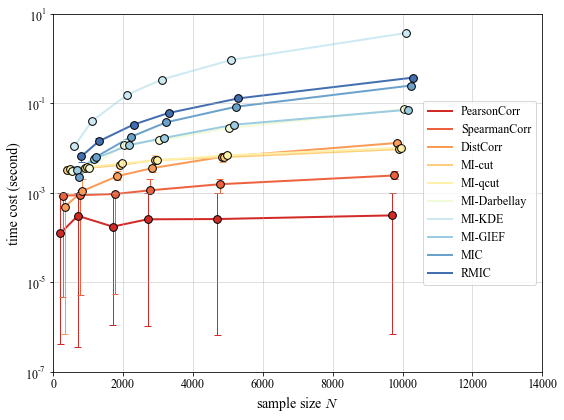

In [7]:
total_tc_df = pd.read_csv("total_tc.csv")
    
plt.figure(figsize=(8, 6))
for method in methods:
    cmap = plt.get_cmap("RdYlBu") # Paired
    cNorm = colors.Normalize(vmin=0, vmax=len(methods) + 1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    method_idx = methods.index(method)
    method_color = scalarMap.to_rgba(method_idx + 1)
    bias = bias_series[method_idx]
    
    line_coords = {"N": [], "mean": []}
    for N in N_lst:
        _df = total_tc_df[total_tc_df[f"N_{method}"]==N]
        tc = _df[f"tc_{method}"].values
        q1, q3 = np.quantile(tc, (0.05, 0.95))
        tc_mean = np.mean(tc)
        line_coords["N"].append(N + bias)
        line_coords["mean"].append(tc_mean)
        
        plt.vlines(N + bias, q1, q3, color=method_color, linewidth=1, zorder=0)
        plt.hlines(q1, N - 100 + bias, N + 100 + bias, color=method_color, linewidth=1, zorder=0)
        plt.hlines(q3, N - 100 + bias, N + 100 + bias, color=method_color, linewidth=1, zorder=0)
        plt.scatter(N + bias, tc_mean, s=60, color=method_color, edgecolor="k", zorder = 1)
    plt.plot(
        line_coords["N"], line_coords["mean"], color=method_color, zorder=-1, linewidth=2, label=method)
    
plt.yscale("log")
plt.ylim([1e-7, 1e1])
plt.xlim([0, 14000])
plt.legend(loc="center right")
plt.xlabel("sample size $N$")
plt.ylabel("time cost (second)")
plt.grid(True, alpha=0.5)
plt.tight_layout()